Import Relevant Libraries, Repo Functions/Definitions

In [1]:
import psycopg2 as pg
import pandas as pd
import numpy as np
from numpy.linalg import lstsq
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

# From Repo
from queries.db_queries import *
from functions.running_avg import *
from functions.helper_functions import *
from configs.definitions import *

Get Data: Team's W/L records, Box Scores

In [2]:
current_teams = sql_query(curr_teams_query)

In [3]:
log_path_2023 = 'C:/Users/conor/Downloads/gl2023/gl2023.txt'
log_path_2022 = 'C:/Users/conor/Downloads/gl2022/gl2022.txt'

gamelogs_2022 = pd.read_csv(log_path_2022, header=None)
gamelogs_2023 = pd.read_csv(log_path_2023, header=None)
gamelogs_2022_2023 = pd.concat([gamelogs_2022, gamelogs_2023])
gamelogs = pd.concat([gamelogs_2022_2023.iloc[:,:13], gamelogs_2022_2023.iloc[:,16:19],gamelogs_2022_2023.iloc[:,102], gamelogs_2022_2023.iloc[:,104]], axis = 1)
gamelogs = gamelogs.set_axis(game_log_column_headers, axis = 1)

#Fix Abbreviations
gamelogs['Visiting Team'] = gamelogs['Visiting Team'].replace(renamed_team)
gamelogs['Home Team'] = gamelogs['Home Team'].replace(renamed_team)

time_window=6 #6 Games for running avergage calculations
running_avg_df = get_running_avg(gamelogs_=gamelogs, timeframe=time_window)

Assess a "Difficulty Score" for each game from the Starting Pitcher's persepctive, based on opponents ability to score runs (overall and as of late)

In [4]:
Difficulty_Score_Home = []
Difficulty_Score_Away = []
for idx, game in gamelogs.iterrows(): #Loop through the boxscores
    date = game['Date']
    home_chllg_run = running_avg_df[(running_avg_df['Date']== date) & (running_avg_df['Visiting Team'] == game['Visiting Team'])]['VTRA_S'].values
    home_chllg_overall = running_avg_df[(running_avg_df['Date']== date) & (running_avg_df['Visiting Team'] == game['Visiting Team'])]['VTA_S'].values
    Difficulty_Score_Home.append(np.average([home_chllg_run,home_chllg_overall], weights= [2,1], axis=0)[0] if len(home_chllg_overall) > 0 else None)

    vis_chllg_run = running_avg_df[(running_avg_df['Date']== date) & (running_avg_df['Home Team'] == game['Home Team'])]['HTRA_S'].values
    vis_chllg_overall = running_avg_df[(running_avg_df['Date']== date) & (running_avg_df['Home Team'] == game['Home Team'])]['HTA_S'].values
    Difficulty_Score_Away.append(np.average([vis_chllg_run,vis_chllg_overall], weights= [2,1], axis=0)[0] if len(vis_chllg_overall) > 0 else None)

gamelogs['Home Challenge'] = Difficulty_Score_Home
gamelogs['Visiting Challenge'] = Difficulty_Score_Away

Use Philadelphia Phillies to Explore visulaizations of this metric

In [5]:
phils = gamelogs[(gamelogs['Visiting Team'] == 'PHI') | (gamelogs['Home Team'] == 'PHI')]
phils = phils.reset_index(drop=True)
for idx, game in phils.iterrows(): #Remove first 5 games of each season
    if game['Visiting Team'] == 'PHI':
        if game['Visiting Team Game Number'] < time_window:
            phils = phils.drop(index = idx)
    else:
         if game['Home Team Game Number'] < time_window:
            phils = phils.drop(index = idx)       

phils = phils.reset_index(drop=True)

phils['Outcome'] = np.where(
    (phils['Home Team'] == 'PHI') & (phils['Home Team Score'] > phils['Visiting Team Score']) | 
    (phils['Visiting Team'] == 'PHI') & (phils['Visiting Team Score'] > phils['Home Team Score']),
    'win', 
    'loss'
)
phils['Opponent'] = np.where( (phils['Home Team'] == 'PHI'), phils['Visiting Team'],phils['Home Team'])
colors = np.where(phils['Outcome'] == 'win', 'green', 'red').tolist() # 

phils['Challenge Score'] = np.where(phils['Home Team'] == 'PHI', phils['Home Challenge'], phils['Visiting Challenge'])

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(phils['Challenge Score'].index, phils['Challenge Score'], c=colors, marker='o', edgecolor='black', s=40, cmap='coolwarm')
plt.title('Phillies Game Difficulty', fontsize=20, fontweight='bold')
plt.xlabel('Game Index', fontsize=14,fontweight='bold')
plt.ylabel('Score', fontsize=14,fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a color legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Win', markerfacecolor='green', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Loss', markerfacecolor='red', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')

# Adding grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.3)

# Adding mean line for reference
mean = phils['Challenge Score'].mean()
plt.axhline(mean, color='gray', linestyle='dashed', linewidth=1)
plt.text(25, mean + 0.12, f'Mean: {mean:.2f}', color='gray', ha='right')

temp_df = avoid_overlap(phils[((phils['Challenge Score'] > 6.75)|(phils['Challenge Score'] < 2.75) )])
for i, row in temp_df.iterrows():
    if row['Home Team'] == 'PHI':
        plt.text(
            x=i - 8,
            y=row['Challenge Score'] + 0.1,
            s=row['Home SP'],
            ha='left',
            weight='bold',
            fontsize=6
        )
    elif row["Visiting Team"] == 'PHI':
          plt.text(
            x=i - 8,
            y=row['Challenge Score'] + 0.1,
            s=row['Visiting SP'],
            ha='left',
            weight='bold',
            fontsize=6
        ) 

Text(0.5, 1.0, '2022/2023 Phillies Season')

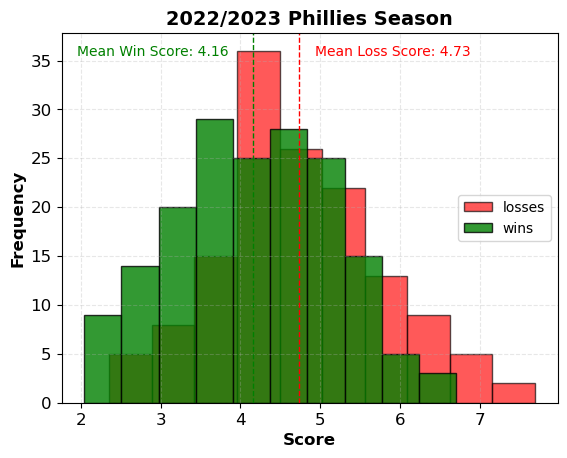

In [8]:
plt.hist(phils['Challenge Score'][ (phils['Outcome']== 'loss')], edgecolor='black', alpha = 0.65, color='red', label='losses')
plt.hist(phils['Challenge Score'][ (phils['Outcome']== 'win')], edgecolor='black', alpha = 0.8, color='green', label = 'wins')
plt.xlabel('Score', fontsize=12,fontweight='bold')
plt.ylabel('Frequency', fontsize=12,fontweight='bold')
#plt.title('Score Histogram', fontsize=16,fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='center right')
loss_mean = np.mean(phils['Challenge Score'][ (phils['Outcome']== 'loss')])
win_mean = np.mean(phils['Challenge Score'][(phils['Outcome']== 'win')])

# Add mean line
plt.axvline(loss_mean, color='red', linestyle='dashed', linewidth=1)
plt.text(loss_mean + 0.2, plt.ylim()[1]*0.94, f'Mean Loss Score: {loss_mean:.2f}', color='red')
plt.axvline(win_mean, color='green', linestyle='dashed', linewidth=1)
plt.text(win_mean - 2.2, plt.ylim()[1]*0.94, f'Mean Win Score: {win_mean:.2f}', color='green')
plt.title('2022/2023 Phillies Season', fontweight='bold', fontsize=14)

Assess IQR Outlier Analysis

In [9]:
q1 = phils['Challenge Score'].quantile(0.25)
q3 = phils['Challenge Score'].quantile(0.75)
iqr = q3 - q1
tough_games = phils[(phils['Challenge Score'] >= q3 + 1.5*iqr) ]
easy_games = phils[(phils['Challenge Score'] <= q1 - 1.5*iqr) ]

In [10]:
score_std = np.std(phils['Challenge Score'])
tough_games = phils[(phils['Challenge Score'] >= mean + 2*score_std)]
easy_games = phils[(phils['Challenge Score'] <= mean - 2*score_std)]
outlier_games = pd.concat([easy_games, tough_games])

Determine A, b and weights for Weighted Least Squares Regression

In [6]:
gamelogs.reset_index(drop=True, inplace=True)

num_feats = 3
num_teams = len(pd.unique(gamelogs[['Home Team', 'Visiting Team']].values.ravel()))
A = np.zeros((162*num_teams*2,num_teams*num_feats)) #162 games, 2 seasons
b = np.zeros((162*num_teams*2,1))

current_teams = current_teams.sort_values(by =['yearid','Team'])
current_teams.reset_index(drop=True, inplace=True)

In [7]:
idx = 0
weights = []
# Group by 'Home Team' and 'Visiting Team' to calculate the occurrence of each matchup
matchup_counts = gamelogs.groupby(['Home Team', 'Visiting Team']).size().reset_index(name='Count')

# Iterate over the grouped matchups
for (home_team, visiting_team), group in gamelogs.groupby(['Home Team', 'Visiting Team']):
    home_team_idx = current_teams.index[(current_teams['Team'] == home_team) & (current_teams['yearid'] == 2022)] #Year Doesn't matter, pick one as long as it exists in df
    visiting_team_idx = current_teams.index[(current_teams['Team'] == visiting_team) & (current_teams['yearid'] == 2022)]
    
    for _, row in group.iterrows():
        # Set offensive team factor
        A[idx, home_team_idx * num_feats] = 1
        A[idx + 1, visiting_team_idx * num_feats] = 1

        # Set defensive team factor
        A[idx, visiting_team_idx * num_feats + 1] = 1
        A[idx + 1, home_team_idx * num_feats + 1] = 1

        # Set park factor (assuming a specific column index for park factors)
        A[idx, home_team_idx * num_feats + 2] = 1  # Adjust this index if park factors are in a different column
        A[idx + 1, home_team_idx * num_feats + 2] = 1

        b[idx] = row['Home Team Score']
        b[idx + 1] = row['Visiting Team Score']
        
        idx += 2
        
        weights.append(len(group))
        weights.append(len(group))

weights = np.array(weights)

Determine Weighted PF

In [8]:
# Add a constant term to the predictors
X = sm.add_constant(A)

# Fit the WLS model
wls_model = sm.WLS(b, X, weights=weights).fit()
beta = wls_model.params 
# Print the summary of the model
#print(wls_model.summary())

In [9]:
# Extract every third coefficient starting from the first coefficient
coefficients = beta[1:]
constant = coefficients[0]

park_factors = []

# Populate the park factor scores
for team in current_teams['Team'][0:30]:
    park_factor = coefficients[current_teams.index[current_teams['Team'] == team][0] * num_feats + 2]
    park_factors.append(park_factor)

# Create a new DataFrame with teams and their corresponding park factor scores
df_park_factors = pd.DataFrame({
    'Team': current_teams['Team'][0:30],
    'ParkFactor': park_factors
}).sort_values(by='ParkFactor', ascending= False)

df_park_factors.reset_index(inplace=True, drop=True)
df_park_factors['NormPF'] = min_max_norm(df_park_factors,'ParkFactor')
print('Weighted Park Factors')
print(round(df_park_factors.sort_values(by='ParkFactor', ascending= False).head(),3))


Weighted Park Factors
  Team  ParkFactor  NormPF
0  COL       1.204   1.000
1  BOS       0.399   0.617
2  TEX       0.202   0.524
3  CIN       0.133   0.492
4  DET       0.021   0.438


Read in Baseball Savant's Park Factor Data

In [19]:
SavantPF = pd.read_csv('C:/Users/conor/Downloads/BaseballSavantPF2023.csv')
SavantPF['NormPF_Savant'] = min_max_norm(SavantPF,'Park Factor')

In [20]:
JoinPFs = pd.merge(df_park_factors, SavantPF, on='Team')
JoinPFs = JoinPFs.drop(columns=['Rank'])
JoinPFs['Diff'] = (abs(JoinPFs['NormPF'] - JoinPFs['NormPF_Savant'])*100).round(3)

In [18]:
JoinPFs.sort_values(by='Diff', ascending=False)

,Team,ParkFactor,NormPF,Park Factor,NormPF_Savant,Diff
6,KCR,-1.155961e-02,0.422748,106,0.65,22.725
15,ATL,-2.534309e-01,0.307929,103,0.50,19.207
13,WSN,-2.135783e-01,0.326847,103,0.50,17.315
23,HOU,-5.284907e-01,0.177354,100,0.35,17.265
8,PIT,-4.392779e-02,0.407383,98,0.25,15.738
12,STL,-1.708872e-01,0.347113,103,0.50,15.289
29,BAL,-9.020928e-01,0.000000,96,0.15,15.000
4,DET,2.104730e-02,0.438227,99,0.30,13.823
22,CLE,-5.176171e-01,0.182516,94,0.05,13.252
1,BOS,3.986622e-01,0.617486,108,0.75,13.251


Adjusting Starting Pitchers ERAs for Difficulty and PF Score

In [10]:
SPs = sql_query(SP_query) #SPs who threw at least 10 games in 2022 and 2023
#phils_pitchers = sql_query(Phils_SP_query) #Phils Pitchers from 2022/2023 with >= 10 Games Started

In [11]:
phils_pitchers = SPs[(SPs['Teams 2022'] == 'PHI') & (SPs['Teams 2023']=='PHI')]

In [ ]:
Names = []
avg_diffs = []
avg_norm_pf = []

home_c_indx = gamelogs.shape[1] - 2
vis_c_indx = gamelogs.shape[1] -1
score_idx = gamelogs.shape[1]

if 'Challenge Score' not in gamelogs:
    gamelogs['Challenge Score'] = np.nan

for pitcher in SPs['Full Name']:
    pf = []
    games_started = gamelogs[(gamelogs['Home SP'] == pitcher) | (gamelogs['Visiting SP'] == pitcher)].reset_index(drop=True)
    for idx, game in games_started.iterrows():
        if games_started.loc[idx,'Home SP'] == pitcher:
            games_started.iloc[idx,score_idx] = games_started.loc[idx,'Home Challenge']
        elif games_started.loc[idx,'Visiting SP'] == pitcher:
            games_started.iloc[idx,score_idx] = games_started.loc[idx,'Visiting Challenge']
        park_factor = df_park_factors['NormPF'][df_park_factors['Team'] == game['Home Team']].values
        if len(park_factor) > 0:
            pf.append(park_factor)
        else:
            print('This Park Has Issues: ',game['Home Team'])
    avg_diff = np.mean(games_started['Challenge Score'])
    avg_norm_pf.append(round(np.mean(pf),2))
    Names.append(pitcher)
    avg_diffs.append(round(avg_diff,2))

Pitchers_2023 = pd.DataFrame({
'Name': Names,
'Avg Game Difficulty Score': avg_diffs,
'2022/2023ERA': round((SPs[['ERA 2022','ERA 2023']]).mean(axis = 1),2),
'PF_Norm': avg_norm_pf,
'ERA Delta' : SPs['ERA CHANGE YOY']
}).sort_values(by='Avg Game Difficulty Score', ascending= False)
    

This Park Has Issues:  []


In [ ]:
# Initialize lists to collect pitcher data
Names = []
avg_diffs_2022 = []
avg_diffs_2023 = []
avg_norm_pf_2022 = []
avg_norm_pf_2023 = []

# Add "Challenge Score" column if it doesn't already exist
if 'Challenge Score' not in gamelogs:
    gamelogs['Challenge Score'] = np.nan
    home_c_indx = gamelogs.shape[1] - 2
    vis_c_indx = gamelogs.shape[1] - 1
    score_idx = gamelogs.shape[1]

# Process each pitcher to calculate stats for 2022 and 2023 separately
for pitcher in SPs['Full Name']:
    pf_2022, pf_2023 = [], []
    games_started = gamelogs[(gamelogs['Home SP'] == pitcher) | (gamelogs['Visiting SP'] == pitcher)].reset_index(drop=True)
    
    for idx, game in games_started.iterrows():
        # Assign challenge scores based on home/visiting team
        if games_started.loc[idx, 'Home SP'] == pitcher:
            games_started.iloc[idx, score_idx] = games_started.loc[idx, 'Home Challenge']
        elif games_started.loc[idx, 'Visiting SP'] == pitcher:
            games_started.iloc[idx, score_idx] = games_started.loc[idx, 'Visiting Challenge']
        
        # Get park factor based on the home team
        park_factor = df_park_factors['NormPF'][df_park_factors['Team'] == game['Home Team']].values
        if len(park_factor) > 0:
            if game['Year'] == 2022:
                pf_2022.append(park_factor)
            elif game['Year'] == 2023:
                pf_2023.append(park_factor)
        else:
            print('This Park Has Issues: ', game['Home Team'])
    
    # Calculate averages for 2022
    games_2022 = games_started[games_started['Year'] == 2022]
    avg_diff_2022 = np.mean(games_2022['Challenge Score']) if not games_2022.empty else 0
    avg_norm_pf_2022.append(round(np.mean(pf_2022), 2) if pf_2022 else 0)

    # Calculate averages for 2023
    games_2023 = games_started[games_started['Year'] == 2023]
    avg_diff_2023 = np.mean(games_2023['Challenge Score']) if not games_2023.empty else 0
    avg_norm_pf_2023.append(round(np.mean(pf_2023), 2) if pf_2023 else 0)

    # Append final results
    Names.append(pitcher)
    avg_diffs_2022.append(round(avg_diff_2022, 2))
    avg_diffs_2023.append(round(avg_diff_2023, 2))

# Create the final DataFrame with separate columns for 2022 and 2023
Pitchers_2023 = pd.DataFrame({
    'Name': Names,
    'Avg Game Difficulty Score 2022': avg_diffs_2022,
    'Avg Game Difficulty Score 2023': avg_diffs_2023,
    '2022 ERA': SPs['ERA 2022'],
    '2023 ERA': SPs['ERA 2023'],
    'PF_Norm 2022': avg_norm_pf_2022,
    'PF_Norm 2023': avg_norm_pf_2023,
    'ERA Delta': SPs['ERA CHANGE YOY']
}).sort_values(by='Avg Game Difficulty Score 2023', ascending=False)

print(Pitchers_2023)


IndexError: iloc cannot enlarge its target object

In [16]:
games_started['Date'] = pd.to_datetime(games_started['Date'], format = '%Y%m%d')

In [15]:
Pitchers_2023.head(25)

,Name,Avg Game Difficulty Score,2022/2023ERA,PF_Norm
106,Ranger Suarez,4.54,3.92,0.34
82,Aaron Nola,4.47,3.86,0.35
119,Zack Wheeler,4.43,3.22,0.33


(array([1., 2., 3., 4., 5., 6., 7., 8.]),
 [Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7'),
  Text(0, 8.0, '8')])

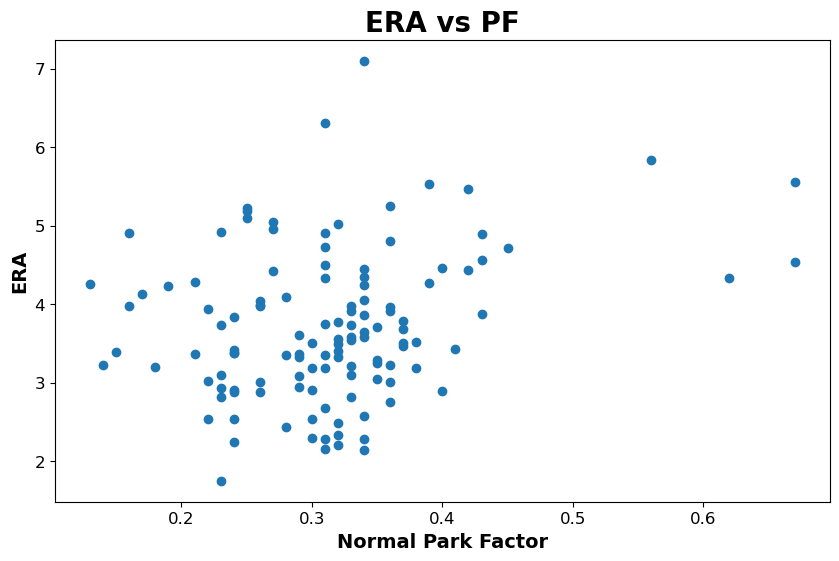

In [102]:
plt.figure(figsize=(10, 6))
plt.scatter(Pitchers_2023['PF_Norm'],Pitchers_2023['2022ERA'])
plt.title('ERA vs PF', fontsize=20, fontweight='bold')
plt.xlabel('Normal Park Factor', fontsize=14,fontweight='bold')
plt.ylabel('ERA', fontsize=14,fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

c:\Users\conor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\conor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

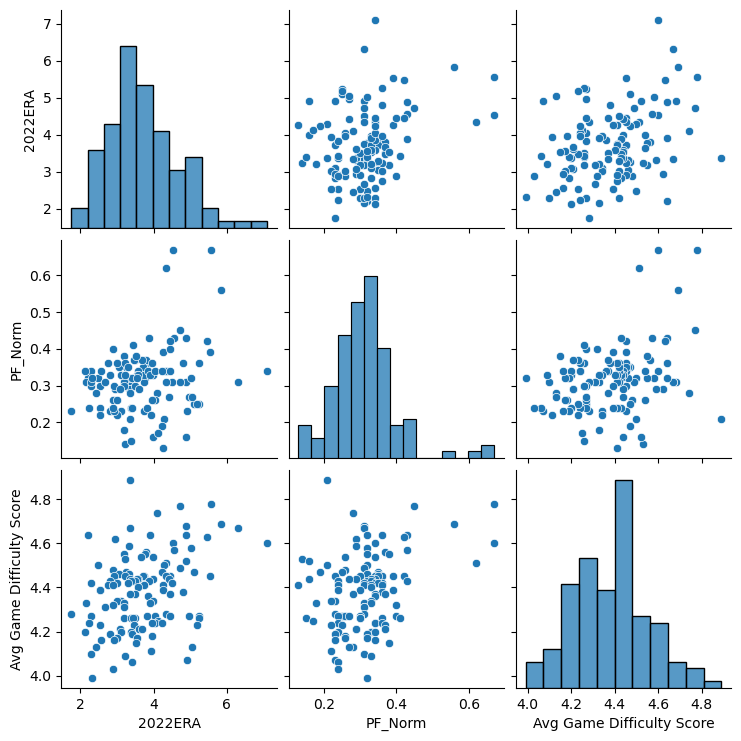

In [104]:
sns.pairplot(Pitchers_2023[['2022ERA','PF_Norm','Avg Game Difficulty Score']])

In [105]:
Pitchers_2023.reset_index(drop=True, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(Pitchers_2023[['PF_Norm','Avg Game Difficulty Score']], Pitchers_2023['2022ERA'], test_size=0.2, random_state=42)
X_train = X_train.to_numpy()
X_test =X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [106]:
inputs = tf.keras.Input(shape=(2,))
dense = tf.keras.layers.Dense(64, activation="relu")
x = dense(inputs)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="ERA_P")
# model = Sequential([
#     tf.keras.layers.Dense(52, activation='relu')(inputs), 
#     tf.keras.layers.Dense(52, activation='relu'), 
#     tf.keras.layers.Dense(1, activation='linear'),  
# ])

In [107]:
model.compile(optimizer='adam',
               loss='mse',
               metrics= ['mae','mse'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [108]:
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, verbose=0, callbacks=[early_stopping])

In [109]:
test_scores = model.evaluate(X_test, y_test, verbose=2)

1/1 - 0s - 73ms/step - loss: 0.8032 - mae: 0.7197 - mse: 0.8032


In [110]:
X_train[0].reshape(1,-1)

array([[0.29, 4.44]])

In [111]:
rand_int = random.ranint(range(len(X_test)))
single_sample = np.array([X_test[rand_int]]).reshape(1, -1)
single_prediction = model.predict(single_sample)
print(single_prediction)

NameError: name 'random' is not defined

In [ ]:
model.predict(X_test)